 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibsonlab/mdsine2_tutorials/blob/main/notebooks/tut_02_inference.ipynb)
 # Tutorial 2: Running inference with the MDSINE2 model and exploring the posterior

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Get data
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/replicates-toy.zip
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/healthy-toy.zip
    
    !mkdir -p ./data/
    !unzip -o healthy-toy.zip -d ./data/ && unzip -o replicates-toy.zip -d ./data/

    !git clone https://github.com/gerberlab/MDSINE2
    !pip install MDSINE2/.

else:
    %cd ..

/home/danmacdonald/Projects/mdsine2_tutorials


In [2]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np 

[DEBUG] Using default logger (stdout, stderr).


## Loading data
Here we load a small preprocessed "toy" dataset created by extracting the 15 most abundant taxa from the full dataset. In the first tutorial, we only looked at the `healthy-toy` dataset. Here, we'll also use the `replicates-toy` dataset to fit our negative binomial measurement model of the microbial count data. 

In [3]:
data_dir = Path('./data/')
replicates_dir = data_dir / 'replicates-toy'
healthy_dir = data_dir / 'healthy-toy'

output_dir = Path('./output/')
fig_dir = Path('./figs/')

output_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)



In [4]:
# Read data
studies = []
for d_dir in [replicates_dir, healthy_dir]:
    tsv_files = sorted(d_dir.glob('*.tsv'))
    tsv_files = {f.stem : f for f in tsv_files}

    # Read data into study object
    study = md2.dataset.parse(
        name = d_dir.stem,
        metadata = tsv_files['metadata'],
        taxonomy = tsv_files['rdp_species'],
        reads = tsv_files['counts'],
        qpcr = tsv_files['qpcr'],
        perturbations = tsv_files['perturbations'],
    )
    studies.append(study)

replicates, healthy = studies


[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations
[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


## Learning the Negative Binomial dispersion parameters
Before running the main inference loop we learn the negative binomial parameters from our physical replicates.
Then, we build the compute graph for learning the model that is used to learn negative binomial parameters.

After that, we'll visualize the fit of the learned negative binomial model. Note: the results in this notebook are not representative of the real results because we're only using the 15 most abundant taxa here.

In [5]:
# set negative binomial model inference parameters
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

# Build the compute graph to learn negative binomial parameters
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=replicates.name, 
    subjset=replicates
    )

# Run inference to learn the negative binomial parameters
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

# Save a0 and a1 for next tutorial
np.savez(data_dir / 'negbin_params.npz', a0=a0, a1=a1)

# Print a summary of a0 and a1 posterior
print('\nLearned parameters a0 and a1:')
print('a0', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0]))
print('a1', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1]))


[DEBUG] Available subjects: M2-D10,M2-D8,M2-D9
[DEBUG] Subject M2-D10, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject M2-D8, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject M2-D9, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[INFO] Setting Single Write, Multiple Read Mode
[INFO] Setting the trace of learned parameters
[INFO] #######################################
[INFO] Setting the trace of Negative binomial dispersion a0
[INFO] Setting the trace of Negative binomial dispersion a1
[INFO] Setting the trace of Filtering
[INFO] Setting the trace for diagnostic variables
[INFO] ##########################################
  0%|          | 1/200 [00:00<00:34,  5.74it/s][DEBUG] Inference iteration 100/200, time: 0.2561795711517334
[DEBUG] Negative binomial dispersion a0: Value: 1.9598217368212737e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.0717629171067232, Acceptance rate: 0.58
[DEBUG] Filtering: no-mp : Time: 0.0005, Acc: [0.333, 0.467, 0.333], da

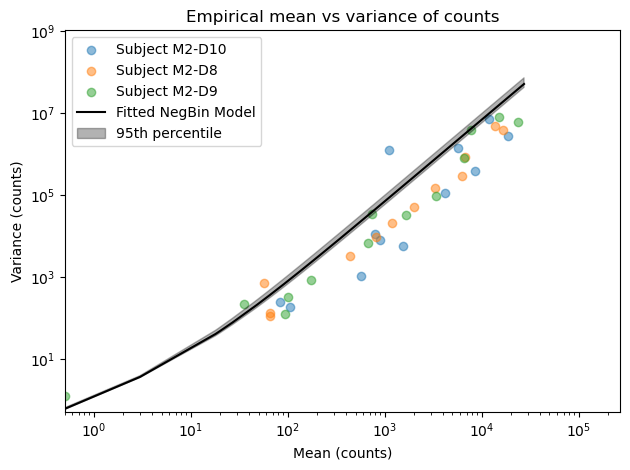

<Figure size 640x480 with 0 Axes>

In [6]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()
plt.show()
plt.savefig(fig_dir / 'negbin_fit.png')


## Run inference on full model
After initializing the parameters of the model, including the dispersion parameters we learned previously, we'll run inference on the MDSINE2 model. We'll run inference twice, using two different intial seeds. 

In [7]:
seeds = [123, 456]
chains = {}

for seed in seeds:
    chain_basepath = output_dir / "mdsine2" / (healthy.name + "{:04d}".format(seed))
    chain_basepath.mkdir(exist_ok=True, parents=True)

    # Initialize parameters of the model 
    params = md2.config.MDSINE2ModelConfig(
        basepath=str(chain_basepath), 
        seed=seed,
        burnin=50, 
        n_samples=100, 
        negbin_a0=a0, negbin_a1=a1, 
        checkpoint=50
    )

    # The default number of modules is 30, which is larger than the number of taxa
    # that we have in this dataset, which would throw a flag.
    params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

    # Initilize the graph
    mcmc = md2.initialize_graph(params=params, graph_name=healthy.name, subjset=healthy)

    # Perform inference
    mcmc = md2.run_graph(mcmc, crash_if_error=True)

    chains[seed] = mcmc


[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 305 qPCR measurements for 3 buckets. Each bucket is 101 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

## Plot posterior distributions
First, we'll create a routine that takes our mcmc object as input and plots posterior quantities, and then we'll plot the distributions from one of our previous inference runs.

In [8]:
def visualize(mcmc, study, seed):
    """ Viz posterior distributions of various paramters. 

    This funciton shows how to extract various posterior quantities from the MDSINE2 
    `mcmc` objects and uses the built-in plotting methods to visualize them. 
    """
    growth = mcmc.graph[STRNAMES.GROWTH_VALUE]
    growth_rates_trace = growth.get_trace_from_disk(section='entire')

    growth_rates_mean = md2.summary(growth)['mean']
    print('Mean growth rates for taxa over posterior', growth_rates_mean)

    # Visualize trace for the first taxa
    ax_growth = md2.visualization.render_trace(growth_rates_trace[:,0], n_burnin=50, **{'title': 'OTU_1 Growth rate'})
    plt.savefig(fig_dir / 'posterior_growth_rates_{:04d}.png'.format(seed))

    # Process variance
    processvar = mcmc.graph[STRNAMES.PROCESSVAR]
    pv_rates_trace = processvar.get_trace_from_disk(section='entire')

    ax_process_var = md2.visualization.render_trace(pv_rates_trace, n_burnin=50, **{'title': 'process variance'})
    plt.savefig(fig_dir / 'posterior_process_variance_{:04d}.png'.format(seed))

    # Taxa module assignments
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    ax_cluster = md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)

    # Create an order
    members = [list(x.members) for x in mcmc.graph[STRNAMES.CLUSTERING_OBJ]]
    members = [item for sublist in members for item in sublist]

    # Visualize co-cluster posterior probability
    coclusters = md2.summary(mcmc.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
    ax_cocluster = md2.visualization.render_cocluster_probabilities(coclusters, taxa=study.taxa,
        yticklabels='%(paperformat)s | %(index)s', order=members)
    plt.savefig(fig_dir / 'posterior_cocluster_probs_{:04d}.png'.format(seed))

    # Visualize trace for number of modules
    ax_n_cluster = md2.visualization.render_trace(clustering.n_clusters)
    plt.savefig(fig_dir / 'posterior_num_modules_trace_{:04d}.png'.format(seed))

    return ax_growth, ax_process_var, ax_cluster, ax_cocluster, ax_n_cluster



[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


Mean growth rates for taxa over posterior [0.72239541 0.74807055 0.38048646 0.95046041 0.81873971 1.00318129
 0.35620907 0.17347257 0.29418281 0.79454652 0.46681216 0.55925312
 0.69843345 0.40261846 0.8614008 ]
[INFO] Number of clusters: 2
[INFO] Clusters assigned: [0 0 0 0 0 0 1 1 0 0 0 0 0 1 0]


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


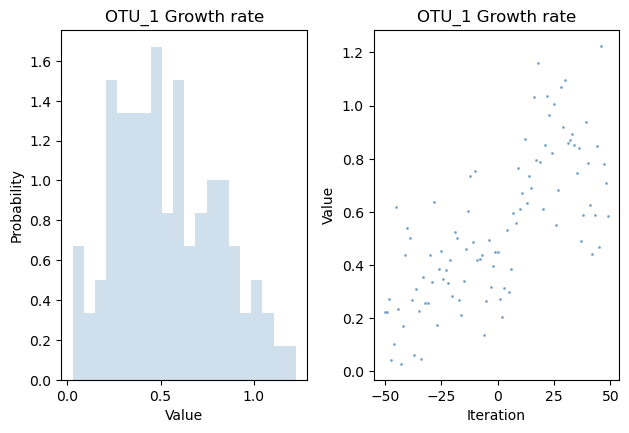

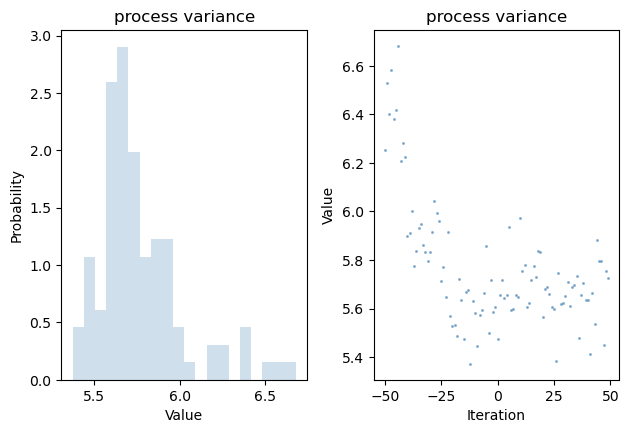

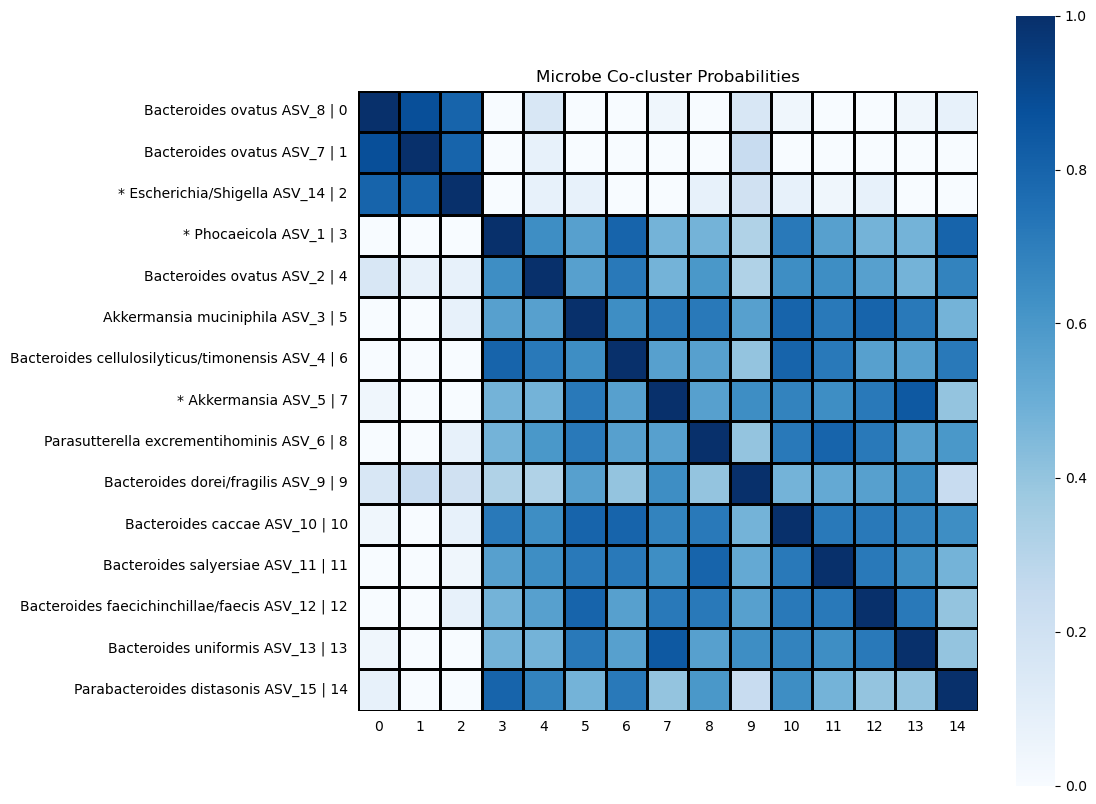

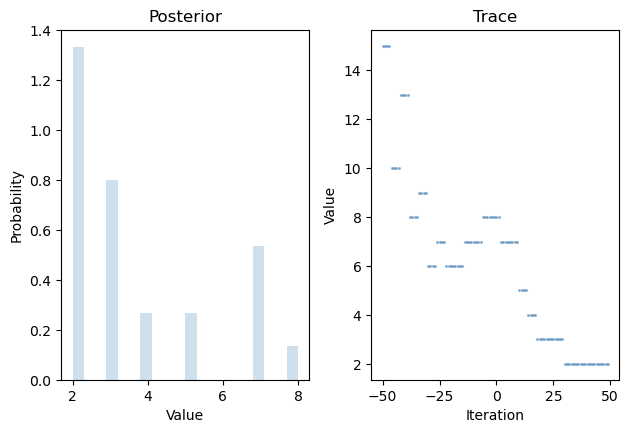

In [9]:
seed = 456
ax_growth, ax_process_var, ax_cluster, ax_cocluster, ax_n_cluster = visualize(chains[seed], healthy, seed)

In [10]:
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

chains_list = [y for k, y in chains.items()]

rhat = md2.pylab.inference.r_hat(chains_list, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains_list, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains_list, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)


Growth parameter r-hat: [0.94929193 1.12426894 1.10504828 0.962244   1.06414447 1.2405695
 1.57738551 0.98034484 0.98271136 1.00708345 0.96511777 1.08544047
 1.10236348 1.00788106 0.95510213]
Concentration parameter r-hat: [2.15655357]
Process variance parameter r-hat: [2.44023721]


## Run inference in fixed-clustering mode
Now that we've identified the modules, we'll run inference again, but this time using `fixed-clustering` mode, which makes it so taxa that share the same cluster share the same growth and interaction parameters.

In [11]:
# Consennss clustering
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(chain_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=healthy.name, subjset=healthy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)


[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 305 qPCR measurements for 3 buckets. Each bucket is 101 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Fixed topology initialization


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 2
[INFO] Clusters assigned: [0 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
[INFO] Clustering set to:
Clustering object (contains ability to change the cluster assignments), n_clusters: 2
Cluster 100490
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_5', 'ASV_6', 'ASV_9', 'ASV_10', 'ASV_11', 'ASV_12', 'ASV_13', 'ASV_15']
	size: 12
Cluster 100491
	members: ['ASV_14', 'ASV_7', 'ASV_8']
	size: 3
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 2
Cluster 100115
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_5', 'ASV_6', 'ASV_9', 'ASV_10', 'ASV_11', 'ASV_12', 'ASV_13', 'ASV_15']
	size: 12
Cluster 100116
	members: ['ASV_14', 'ASV_7', 'ASV_8']
	size: 3
[INFO] Initializing Process Variance parameter
[INFO] Initializing Mean parameter for the truncated normal prior of the growth parameter
[INFO] Initializing Variance parameter for the truncated normal prior of the growth parameter
[INFO] In

# Plot bayes factors for module-module interactions


[WARNING] Automatically setting xlabels as index because there are no taxa


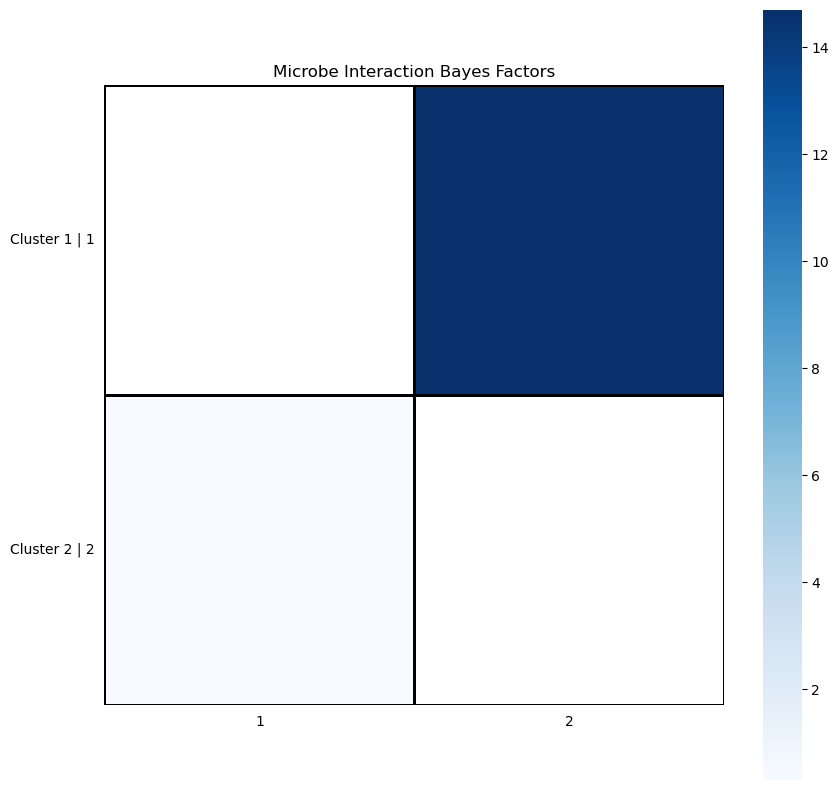

In [12]:
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
ax_bayes = md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.savefig(fig_dir / 'posterior_fix_assignments_{:04d}.png'.format(seed))